# 01_EDA — Исследовательский анализ данных
**Цель:** проверка качества, полноты и структурирование данных для последующего анализа.

# Импорт библиотек

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from datetime import timedelta
from dateutil import parser

# Загрузка данных

In [32]:
visits = pd.read_csv('data/processed/visits.csv')
channels = pd.read_csv('data/processed/channels.csv')

In [33]:
print('VISITS TABLE')
display(visits.head(3))

print('CHANNELS TABLE')
display(channels.head(3))

VISITS TABLE


,Дата оплаты,Номер чека,Администратор,Пациент,Врач,Код услуги,Услуга,"Цена, ₽","Кол-во, шт.","Скидка, ₽","Бонусы, ₽","Сумма, ₽",Способ оплаты,Признак расчёта,Тип операции,Рекомендатель
0,09:49 02.10.2025,1787,A008,P000867,D001,NaN,Пополнение депозита,2700,1,0,0,2700,Картой,Приход,Аванс,R0001
1,18:48 01.10.2025,1784,A008,P000920,D003,B01.047.001,"Прием (осмотр, консультация) врача-терапевта",1150,1,0,0,1150,Картой,Приход,Полный расчет,R0001
2,17:44 01.10.2025,1783,A008,P000835,D014,A12.09.001,Спирография с пробой с бронхолитиками (с оценк...,1100,1,0,0,1100,Картой,Приход,Полный расчет,R0001


CHANNELS TABLE


,Дата приёма,Дата первого приема,Дата первого приема по каналу,Канал,Пациент,Врач,Администратор,"Сумма оказанных услуг, ₽"
0,10.06.2025,19.05.2025,19.05.2025,2GIS,P000743,D020,A004,2500
1,03.06.2025,19.05.2025,19.05.2025,2GIS,P000743,D020,A004,2500
2,26.05.2025,19.05.2025,19.05.2025,2GIS,P000743,D020,A008,2500


# Обработка пропусков

В таблице множество пропусков, которые метод info() не обнаруживает. Необходимо сначала сделать их настоящими пропусками.

In [34]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1916 entries, 0 to 1915
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Дата оплаты      1916 non-null   object
 1   Номер чека       1916 non-null   int64 
 2   Администратор    1916 non-null   object
 3   Пациент          1916 non-null   object
 4   Врач             1916 non-null   object
 5   Код услуги       1888 non-null   object
 6   Услуга           1916 non-null   object
 7   Цена, ₽          1916 non-null   int64 
 8   Кол-во, шт.      1916 non-null   int64 
 9   Скидка, ₽        1916 non-null   int64 
 10  Бонусы, ₽        1916 non-null   int64 
 11  Сумма, ₽         1916 non-null   int64 
 12  Способ оплаты    1916 non-null   object
 13  Признак расчёта  1916 non-null   object
 14  Тип операции     1916 non-null   object
 15  Рекомендатель    1916 non-null   object
dtypes: int64(6), object(10)
memory usage: 239.6+ KB


In [35]:
channels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Дата приёма                    1572 non-null   object
 1   Дата первого приема            1572 non-null   object
 2   Дата первого приема по каналу  1572 non-null   object
 3   Канал                          1572 non-null   object
 4   Пациент                        1572 non-null   object
 5   Врач                           1572 non-null   object
 6   Администратор                  1572 non-null   object
 7   Сумма оказанных услуг, ₽       1572 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 98.4+ KB


In [36]:
# Исправление формата дат таблицы visits
visits['Дата оплаты'] = visits['Дата оплаты'].apply(lambda x: parser.parse(x, dayfirst=True))

# Исправление формата дат таблицы channels
datetime_columns = ['Дата приёма', 'Дата первого приема', 'Дата первого приема по каналу']
for col in datetime_columns:
    channels[col] = (
        channels[col]
        .apply(
            lambda x: (parser.parse(x, dayfirst=True) if isinstance(x, str) else x)
                      if pd.notnull(x) else pd.NaT
        )
    )

In [37]:
# Анализ проводится в начале октября, поэтому рационально будет использовать строки по сентябрь включительно
rows_to_save = visits['Дата оплаты'].between('2025-01-01', '2025-09-30', inclusive='both')
visits = visits.loc[rows_to_save, :]

rows_to_save = channels['Дата приёма'].between('2025-01-01', '2025-09-30', inclusive='both')
channels = channels.loc[rows_to_save, :]

In [38]:
# В excel видно, что во всех колонках ложно-пустыми значениями являются символ пробела и две точки
# Пропуски есть только в таблице visits

visits = visits.replace([" ", " . ."], np.nan)

# Обработка дубликатов

In [39]:
# Дублирующиеся строки
visits.duplicated().value_counts()

False    1865
True        2
Name: count, dtype: int64

In [40]:
# Проверка чеков по задублированным строкам
duplicated_rows_checks_ids = visits.loc[visits.duplicated(), 'Номер чека']
visits[visits['Номер чека'].isin(duplicated_rows_checks_ids)]

,Дата оплаты,Номер чека,Администратор,Пациент,Врач,Код услуги,Услуга,"Цена, ₽","Кол-во, шт.","Скидка, ₽","Бонусы, ₽","Сумма, ₽",Способ оплаты,Признак расчёта,Тип операции,Рекомендатель
1142,2025-06-24 10:38:00,844,A008,P000869,D006,A11.12.003,Внутривенное капельное введение лекарственных...,600,1,60,0,540,Авансом,Приход,Полный расчет,R0001
1143,2025-06-24 10:38:00,844,A008,P000869,D006,A11.12.003,Внутривенное капельное введение лекарственных...,600,1,60,0,540,Авансом,Приход,Полный расчет,R0001
1298,2025-06-11 10:49:00,737,A004,P000022,D013,14.13.A1,Посев желчи на микрофлору с определением чувст...,1677,1,0,0,1677,Картой,Приход,Полный расчет,R0009
1299,2025-06-11 10:49:00,737,A004,P000022,D013,14.13.A1,Посев желчи на микрофлору с определением чувст...,1677,1,0,0,1677,Картой,Приход,Полный расчет,R0009
1300,2025-06-11 10:49:00,737,A004,P000022,D013,A11.16.007,Дуоденальное зондирование диагностическое,5500,1,0,0,5500,Картой,Приход,Полный расчет,R0001


Количество и сумма дубликатов незначительные, кроме того они могут быть получены в результате проведения оплаты по одинаковым услугам в рамках одного чека.

В данном случае не стоит удалять дублирующиеся строки.

# Первичный анализ данных

## Блок подготовки данных к анализу

### Переименовывание колонок

In [41]:
# Rename columns
col_map_visits = {
    "Дата оплаты": "pay_datetime",          # дата оплаты
    "Номер чека": "check_id",           # номер чека
    "Администратор": "admin_id",        # администратор
    "Пациент": "pat_id",                # пациент
    "Врач": "doc_id",                   # врач
    "Код услуги": "service_code",       # код услуги
    "Услуга": "service_name",           # наименование услуги
    "Цена, ₽": "price_rub",             # цена за единицу в чеке
    "Кол-во, шт.": "qty",               # количество
    "Скидка, ₽": "discount_rub",        # скидка
    "Бонусы, ₽": "bonus_rub",           # бонусы
    "Сумма, ₽": "amount_rub",           # сумма операции (итог)
    "Способ оплаты": "payment_method",  # способ оплаты (нал/карта)
    "Признак расчёта": "cashflow_type", # приход/возврат
    "Тип операции": "op_type",          # полный расчёт / аванс
    "Рекомендатель": "referrer_id"      # рекомендатель (врач)
}

col_map_channels ={
    "Дата приёма": "visit_date",                 # дата визита
    "Дата первого приема": "first_visit_date",   # первый визит пациента
    "Дата первого приема по каналу": "first_channel_date", # первый визит по этому каналу
    "Канал": "channel",                          # канал привлечения
    "Пациент": "pat_id",                         # пациент
    "Врач": "doc_id",                            # врач
    "Администратор": "admin_id",                 # администратор
    "Сумма оказанных услуг, ₽": "services_sum_rub" # сумма оказанных услуг
}

In [42]:
visits.rename(columns=col_map_visits, inplace=True, errors='ignore')
channels.rename(columns=col_map_channels, inplace=True, errors='ignore')

print("Replacing done!\n".upper())
print(f"VISITS COLUMNS: \n{visits.columns}\n")
print(f"CHANNELS COLUMNS:\n{channels.columns}")

REPLACING DONE!

VISITS COLUMNS: 
Index(['pay_datetime', 'check_id', 'admin_id', 'pat_id', 'doc_id',
       'service_code', 'service_name', 'price_rub', 'qty', 'discount_rub',
       'bonus_rub', 'amount_rub', 'payment_method', 'cashflow_type', 'op_type',
       'referrer_id'],
      dtype='object')

CHANNELS COLUMNS:
Index(['visit_date', 'first_visit_date', 'first_channel_date', 'channel',
       'pat_id', 'doc_id', 'admin_id', 'services_sum_rub'],
      dtype='object')


### Количество уникальных записей в признаках для проверки

Выбрана часть данных, так как остальная часть просмотрена вручную в Excel

In [43]:
print('Таблица visits'.upper())
print(f'Уникальных пациентов: {visits['pat_id'].nunique()}')
print(f'Уникальных врачей: {visits['doc_id'].nunique()}')
print(f'Уникальных услуг: {visits['service_code'].nunique()}')
print(f'Способов оплаты: {visits['payment_method'].nunique()}')

print()

print('Таблица каналов'.upper())
print(f'Уникальных пациентов: {channels['pat_id'].nunique()}')
print(f'Уникальных врачей: {channels['doc_id'].nunique()}')
print(f'Уникальных каналов: {channels['channel'].nunique()}')


ТАБЛИЦА VISITS
Уникальных пациентов: 889
Уникальных врачей: 21
Уникальных услуг: 202
Способов оплаты: 5

ТАБЛИЦА КАНАЛОВ
Уникальных пациентов: 922
Уникальных врачей: 20
Уникальных каналов: 7


### Проверка способов оплаты на репрезентативность категорий

In [44]:
visits.groupby(['payment_method'])['amount_rub'].count().sort_values(ascending=False).reset_index(name='Количество транзакций')

,payment_method,Количество транзакций
0,Картой,1596
1,Наличными,236
2,Авансом,21
3,Авансом и картой,13
4,Наличными и картой,1


In [45]:
visits.groupby(['payment_method'])['amount_rub'].sum().sort_values(ascending=False).reset_index(name='Сумма транзакций')

,payment_method,Сумма транзакций
0,Картой,2611014
1,Наличными,315239
2,Авансом,19650
3,Авансом и картой,6020
4,Наличными и картой,2000


"Авансом и картой" и "Наличными и картой" занимает малую долю операций как по сумме, так и по количеству. Рационально будет отнести их к другим катгеориям.

In [46]:
visits.replace({'Авансом и картой': 'Картой', 'Наличными и картой': 'Наличными'}, inplace=True)
visits.groupby(['payment_method'])['amount_rub'].sum().sort_values(ascending=False).reset_index(name='Сумма транзакций')

,payment_method,Сумма транзакций
0,Картой,2617034
1,Наличными,317239
2,Авансом,19650


### Проверка признака расчёта на репрезентативность категорий

In [47]:
# Расчет количества операций
visits.groupby('cashflow_type')['amount_rub'].count().sort_values(ascending=False).reset_index(name='Количество операций')

,cashflow_type,Количество операций
0,Приход,1866
1,Возврат прихода,1


In [48]:
# Расчет суммы операций
visits.groupby('cashflow_type')['amount_rub'].sum().sort_values(ascending=False).reset_index(name='Сумма операций')

,cashflow_type,Сумма операций
0,Приход,2955023
1,Возврат прихода,-1100


Сумма возвратов незначительная, можно пренебречь ею для анализа

In [49]:
# Удаление лишних строк
rows_to_drop = visits.loc[:, 'cashflow_type'] == "Возврат прихода"
visits = visits.loc[~rows_to_drop, :]
visits.groupby('cashflow_type')['amount_rub'].sum().sort_values(ascending=False).reset_index(name='Сумма операций')

,cashflow_type,Сумма операций
0,Приход,2955023


### Проверка типа операции на репрезентативность категорий

In [50]:
# Количество интересующий операций
visits[visits['op_type'] == 'Аванс']['service_name'].value_counts().reset_index(name='Количество операций')

,service_name,Количество операций
0,Пополнение депозита,7


In [51]:
# Расчет суммы операций
visits.groupby('op_type')['amount_rub'].sum().sort_values(ascending=False).reset_index(name='Сумма операций')

,op_type,Сумма операций
0,Полный расчет,2933973
1,Аванс,21050


Тип операций отражает либо оплату, либо пополнение депозита.

Количество операций, как и сумма операций, достаточно малы. Поэтому рационально исключить пополнение депозита из анализа.

In [52]:
# Удаление лишних строк
rows_to_drop = visits.loc[:, 'op_type'] == "Аванс"
visits = visits.loc[~rows_to_drop, :]
visits.groupby('op_type')['amount_rub'].sum().sort_values(ascending=False).reset_index(name='Сумма операций')

,op_type,Сумма операций
0,Полный расчет,2933973


### Проверка дат на консистентность

In [53]:
# Список пациентов с количеством посещений
patients = channels.groupby(['pat_id'])['visit_date'].count().sort_values(ascending=False)

# Всегда ли совпадает "Дата первого приема" и "Дата первого приема по каналу"?
(channels['first_visit_date'] - channels['first_channel_date']) \
.reset_index(name=['Уникальные значения разницы дней']).nunique()

index                                 1561
[Уникальные значения разницы дней]       1
dtype: int64

Нет разницы между "Дата первого приема" и "Дата первого приема по каналу".

In [54]:
# Удаление столбца с дублирующейся информацией
channels.drop(['Дата первого приема по каналу'], inplace=True, errors='ignore')

### Проверка на консистентность информации по пациентам

Количество уникальных пациентов в таблице первых записей выше, чем в таблице посещений.

Необходимо понять в чем причина.

In [55]:
# Множества с уникальными пациентами
patients_set1 = set(visits['pat_id'].to_list())
patients_set2 = set(channels['pat_id'].to_list())

# missed patients at all
missed_patients = patients_set1.symmetric_difference(patients_set2)

print(f"Пациенты, встречающиеся лишь в одной таблице: {len(missed_patients)}")

Пациенты, встречающиеся лишь в одной таблице: 35


Между таблицами channels (записи) и visits (кассовые операции) обнаружены расхождения: 35 пациентов присутствуют только в одной из таблиц.

После включения данных за октябрь количество расхождений сокращается, однако часть несоответствий сохраняется (19 записей к концу июля).

Это указывает, что ошибка не связана с временными задержками обновления, а имеет структурный характер — данные расходятся уже на этапе формирования выгрузок.

Для дальнейшего анализа это важно учитывать: несовпадение множеств пациентов может влиять на корректность метрик выручки, retention и первичных визитов.

In [56]:
# Пациенты, присуствующие только в visits
print('Пациенты, присуствующие только в visits')
display(
    visits.loc[
        visits['pat_id'].isin(missed_patients),
        ['pat_id', 'amount_rub']
    ].rename(columns={'amount_rub': 'service_income_sum'})
)

Пациенты, присуствующие только в visits


,pat_id,service_income_sum
283,P000780,1100


In [57]:
# Пациенты, присуствующие только в channels
tmp = channels.loc[
                channels['pat_id'].isin(missed_patients),
                ['pat_id', 'services_sum_rub']]

print('Пациенты, присуствующие только в channels\n', tmp['pat_id'].nunique())
print(f"Выручка от них: {tmp['services_sum_rub'].sum()} руб.")

Пациенты, присуствующие только в channels
 34
Выручка от них: 66759 руб.


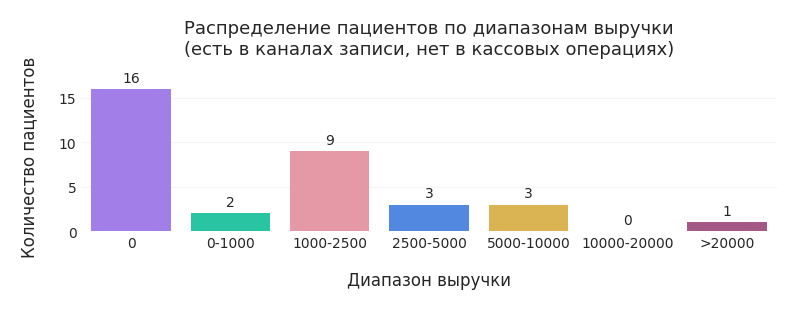

In [58]:
# Пациенты, присуствующие только в channels
missed_patients_data = (
    channels.loc[
        channels['pat_id'].isin(missed_patients),
    ].groupby('pat_id')                                     # Группировка для проверки значимости пропущенных записей для анализа
    .agg(
        service_income_sum = ('services_sum_rub', 'sum'),
        services_count = ('services_sum_rub', 'count')
    ).sort_values('services_count', ascending=False)
    .assign(income_range=lambda x: "0" )
    .reset_index()
)

bins = [-1, 0, 1000, 2500, 5000, 7500, 20000, float('inf')]
labels = ['0', '0-1000', '1000-2500', '2500-5000', '5000-10000', '10000-20000', '>20000']

missed_patients_data['income_sum_range'] = pd.cut(missed_patients_data['service_income_sum'], bins, right=True, labels=labels)
grouped = missed_patients_data.groupby('income_sum_range', observed=False)['pat_id'].count().reset_index(name='cnt')

fig, ax = plt.subplots(figsize=(8, 3))

sns.barplot(
    data=grouped,
    x='income_sum_range',
    y='cnt',
    hue='income_sum_range',
    order=grouped['income_sum_range'],
    ax=ax,
    legend=False  # скрываем лишнюю легенду, если она дублирует подписи
)

# Добавляем подписи
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Украшаем
ax.set_xlabel('Диапазон выручки')
ax.set_ylabel('Количество пациентов')
ax.set_title('Распределение пациентов по диапазонам выручки\n(есть в каналах записи, нет в кассовых операциях)')
# ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

plt.savefig(
    "reports/visualisation/fig01_missed_patients_revenue_distribution.png",  # путь к сохранённому файлу
    dpi=300,          # высокое качество (для печати и PDF)
    bbox_inches="tight",  # убирает лишние поля
    transparent=False  # фон остаётся белым
)
plt.show()


Пациентов, уникальных для таблицы channels, немного. Однако среди них пристуствует один с 9 посещениями за 6 разных дней. Это значимое наблюдение для анализа удержания клиентов.

Если данные по выручке между таблицами окажутся неконсистентными, то таблица ***channels*** станет источником информации о привлечении пациентов, а таблица ***visits*** - источником информации для расчета финансовых показателей.

### Проверка на консистентность информации по выручке

#### Подготовка кумулятивных данных

In [59]:
# --- Вставка в visits столбца с датой --- #
dates_visits = visits['pay_datetime'].dt.normalize()             # урезание дат до начала дня для группировки
visits.insert(loc=1, column='date', value=dates_visits)

# --- Определение списка недостающих дат --- #
# Определение минимальной даты для заполнения данных в пропущенные дни
min_date = min(
    visits['date'].min(),
    channels['visit_date'].min()
)

# Определение максимальной даты для заполнения данных в пропущенные дни
max_date = max(
    visits['date'].max(),
    channels['visit_date'].max()
)

# Определение полного календарного периода дат
date_index = pd.date_range(min_date, max_date, freq='D')


# --- Заполнение пропущенных дат --- #
# Группировка данных по дневной выручке
daily_revenue_visists = visits.groupby('date')['amount_rub'].sum()
daily_revenue_channels = channels.groupby('visit_date')['services_sum_rub'].sum()

# Заполнение пропущенных дат
daily_revenue_visists = daily_revenue_visists.reindex(date_index).fillna(0)
daily_revenue_channels = daily_revenue_channels.reindex(date_index).fillna(0)

# Создание серий кумулятивного накопления выручки
cumulative_daily_revenue_visists = daily_revenue_visists.cumsum()
cumulative_revenue_channels = daily_revenue_channels.cumsum()

#### Визуализация расхождения выручки между таблицами

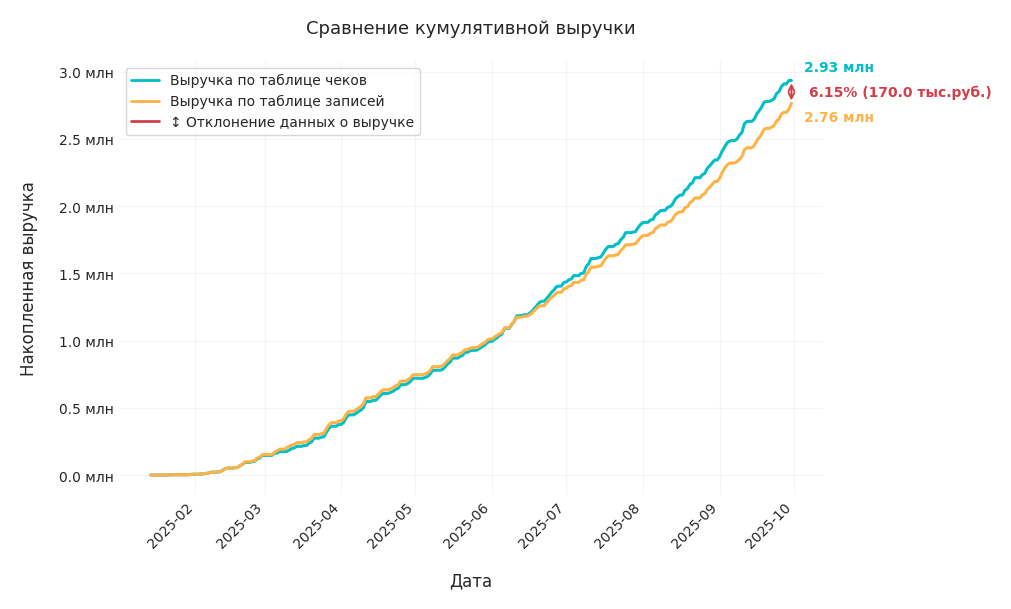

In [60]:
# Блок визуализации

# 1️⃣ Подключаем готовый стиль
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.style.use('styles/clinic_analytics_pitaya.mplstyle')

# Основные цвета
color_visits = "#00bfc6"   
color_channels = "#ffb347"  
arrow_color = "#d33f49"    

# 2️⃣ Создаём фигуру и ось
fig, ax = plt.subplots(figsize=(10,6))

# 3️⃣ Строим линии выручки
ax.plot(
    cumulative_daily_revenue_visists,
    label='Таблица чеков',
    linewidth=2.2,
    color=color_visits
)
ax.plot(
    cumulative_revenue_channels,
    label='Таблица записей',
    linewidth=2.2,
    color=color_channels
)

# 4️⃣ Настраиваем заголовок и оси
ax.set_title("Сравнение кумулятивной выручки", pad=20)
ax.set_xlabel('Дата', labelpad=15)
ax.set_ylabel('Накопленная выручка', labelpad=15)

# Форматируем ось Y — в миллионах
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f} млн")
)

# Форматируем ось X — каждая метка = месяц
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# 5️⃣ Расчёт расхождения между таблицами
x_last = cumulative_daily_revenue_visists.index[-1]
y_visits = cumulative_daily_revenue_visists.iloc[-1]
y_channels = cumulative_revenue_channels.iloc[-1]
diff_abs = y_visits - y_channels           # абсолютная разница в рублях
diff_pct = diff_abs / y_channels * 100     # относительная разница (%)

# 6️⃣ Добавляем подписи и стрелку
y_min, y_max = ax.get_ylim()
y_offset = (y_max - y_min) * 0.015  # вертикальный отступ для надписей

# Подписи к концам линий
ax.text(
    x_last + timedelta(days=5), y_visits + y_offset,
    f"{y_visits/1e6:.2f} млн",
    color=color_visits, va="bottom", ha="left", weight="bold"
)
ax.text(
    x_last + timedelta(days=5), y_channels - y_offset,
    f"{y_channels/1e6:.2f} млн",
    color=color_channels, va="top", ha="left", weight="bold"
)

# Стрелка между линиями
ax.annotate(
    "",
    xy=(x_last, y_visits),
    xytext=(x_last, y_channels),
    arrowprops=dict(arrowstyle="<->", color=arrow_color, lw=1.4)
)

# Подпись процента расхождения
ax.text(
    x_last + timedelta(days=7),
    (y_visits + y_channels) / 2,
    f"{diff_pct:.2f}% ({diff_abs/1000:.1f} тыс.руб.)",
    va="center", ha="left",
    weight="bold", color=arrow_color
)

# 7️⃣ Легенда с пояснением
# Добавляем фиктивную линию для стрелки, чтобы упомянуть отклонение
legend_arrow = plt.Line2D([0], [0], color=arrow_color, lw=2)
ax.legend(
    handles=[
        plt.Line2D([0], [0], color=color_visits, lw=2, label='Выручка по таблице чеков'),
        plt.Line2D([0], [0], color=color_channels, lw=2, label='Выручка по таблице записей'),
        legend_arrow
    ],
    labels=[
        "Выручка по таблице чеков",
        "Выручка по таблице записей",
        "↕ Отклонение данных о выручке"
    ],
    frameon=True,
    loc='upper left'
)

plt.tight_layout()

# Сохранение итогового изображения в отчёт
plt.savefig(
    "reports/visualisation/fig02_cumulative_revenue_comparison.png",  # путь к сохранённому файлу
    dpi=300,          # высокое качество (для печати и PDF)
    bbox_inches="tight",  # убирает лишние поля
    transparent=False  # фон остаётся белым
)
# 8️⃣ Завершаем оформление

plt.show()

Суммарная выручка по таблице чеков превышает выручку по журналу записей примерно на 6% (≈170 тыс. руб.).

Такое расхождение можно считать существенным, особенно если данные из этих таблиц используются в анализе совместно.

***Интерпретация таблиц:***

- Таблица visits отражает фактические финансовые транзакции → подходит для расчётов unit-экономики, выручки, среднего чека.

- Таблица channels фиксирует посещения и взаимодействие с клиникой → лучше использовать для анализа поведения, вовлечения и удержания пациентов.

***Вывод:***
- Для дальнейших расчётов следует разделять аналитику поведения и финансовую аналитику, чтобы избежать искажений в метриках.

***Проблема:***
- Таблица чеков не содержит информацию по каналам привлечения;
- Таблица channels не содержит перечень услуг или их категорию;
- Имеющееся и нарастающее различие данных между таблицами не дает объединить таблицы по (дата, пациент) без смещения выводов.

## Аналитический блок

### Общие показатели

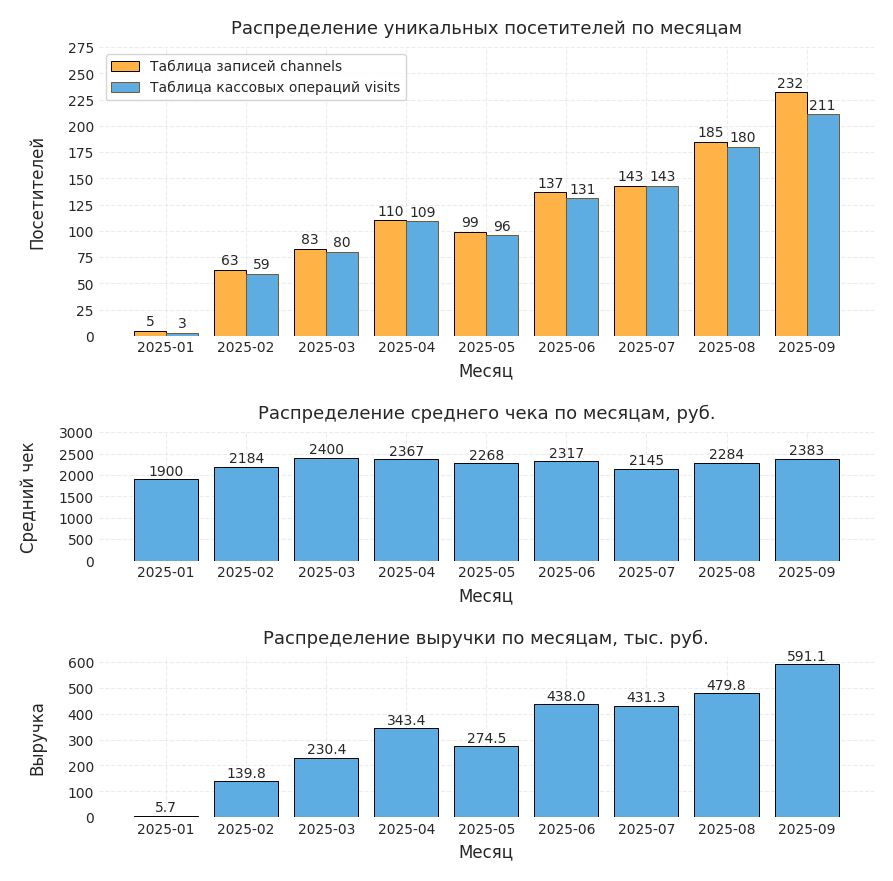

In [31]:
# Визуализация общих показателей

# === Предварительные расчеты === #
# Количество уникальных посетителей channels
channels['month'] = channels['visit_date'].dt.strftime('%Y-%m')
unique_patients_channels = channels.groupby('month')['pat_id'].nunique()

# Количество уникальных посетителей visits
visits['month'] = visits['date'].dt.strftime('%Y-%m')
unique_patients_visits = visits.groupby('month')['pat_id'].nunique()

# Расчёт среднего чека
groupped_by_check = visits.groupby(['check_id', 'month'], as_index=False)['amount_rub'].sum()
avg_check = groupped_by_check.groupby('month')['amount_rub'].mean()

# Расчет выручки
revenue = visits.groupby('month')['amount_rub'].sum()


# === Визуализация === #
# Подготовка данных для оси X
months = unique_patients_channels.index
x = np.arange(len(months))
width = 0.4

# Создание общей фигуры с разными пропорциями высоты
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(3, 1, height_ratios=[2.7, 1.2, 1.5], hspace=0.5)

# --- Первый график: уникальные посетители ---
ax1 = fig.add_subplot(gs[0])

ax1.bar(x - width/2, unique_patients_channels.values,
        width=width,
        color="#ffb347",
        edgecolor="black",
        linewidth=0.7,
        label="Таблица записей channels")

ax1.bar(x + width/2, unique_patients_visits.values,
        width=width,
        color="#5DADE2",
        edgecolor="#7a5726",
        linewidth=0.7,
        label="Таблица кассовых операций visits")

ax1.set_xticks(x)
ax1.set_xticklabels(months, fontsize=10, rotation=0)
ax1.set_yticks(range(0, 300, 25))
ax1.set_yticklabels(range(0, 300, 25), fontsize=10)
ax1.set_xlabel('Месяц', labelpad=5)
ax1.set_ylabel('Посетителей')
ax1.set_title('Распределение уникальных посетителей по месяцам', pad=10)
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.7)

# Аннотации
for i, v in enumerate(unique_patients_channels.values):
    ax1.text(i - width/2, v + 5, str(v), fontsize=10, ha='center')

for i, v in enumerate(unique_patients_visits.values):
    ax1.text(i + width/2, v + 5, str(v), fontsize=10, ha='center')

# --- Второй график: средний чек ---
ax2 = fig.add_subplot(gs[1])

ax2.bar(avg_check.index,
        avg_check.values,
        color="#5DADE2",
        edgecolor="black",
        linewidth=0.7)

ax2.set_title('Распределение среднего чека по месяцам, руб.', pad=10)
ax2.set_xlabel('Месяц', labelpad=5)
ax2.set_ylabel('Средний чек')
ax2.set_yticks(range(0, 3500, 500))
ax2.set_yticklabels(np.arange(0, 3500, 500), fontsize=10)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(months, fontsize=10)

for i, v in enumerate(avg_check.values):
    ax2.text(i, v + 100, str(int(v)), fontsize=10, ha='center')

# --- Третий график: выручка ---
ax3 = fig.add_subplot(gs[2])

ax3.bar(revenue.index,
        revenue.values,
        color="#5DADE2",
        edgecolor="black",
        linewidth=0.7)

ax3.set_title('Распределение выручки по месяцам, тыс. руб.', pad=10)
ax3.set_xlabel('Месяц', labelpad=5)
ax3.set_ylabel('Выручка')
ax3.grid(True, linestyle="--", alpha=0.7)
ax3.set_xticks(x)
ax3.set_xticklabels(months, fontsize=10)
ax3.set_yticks(np.arange(0, 650e3, 100e3))
ax3.set_yticklabels(np.arange(0, 650, 100), fontsize=10)


for i, v in enumerate(revenue.values):
    ax3.text(i, v + 1e4 + 6000, f'{v/1e3:.1f}', fontsize=10, ha='center')

# Сохранение и отображение
plt.savefig(
    "reports/visualisation/fig03_monthly_visitors_check_revenue_comparison.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

### Динамика уникальных пациентов

После летней стабилизации наблюдается заметный рост числа пациентов, начинающийся в августе.

При этом возможен сезонный фактор:

- Август — время завершения отпусков, когда пациенты возвращаются к плановым визитам.

- Сентябрь — традиционный пик заболеваемости и период получения медицинских справок для школ и организаций.

Поэтому рост может быть вызван не столько маркетинговыми усилиями, сколько повышением естественного спроса.

Чтобы понять природу этого роста, требуется уточнить, какие категории пациентов и каналы обеспечили увеличение обращений.


***Гипотеза (H1): рост пациентов вызван сезонными факторами.***

Дополнительное исследование:

- Разбить пациентов по каналам привлечения, чтобы понять, в каких именно каналах наблюдался прирост.

- Построить распределение первичных и вторичных пациентов по месяцам.

***Гипотеза (H2): рост пациентов в августе–сентябре обеспечен в основном за счёт возвратных клиентов, а retention новой аудитории потенциально низкий.***

#### Распределение пациентов по каналам привлечения

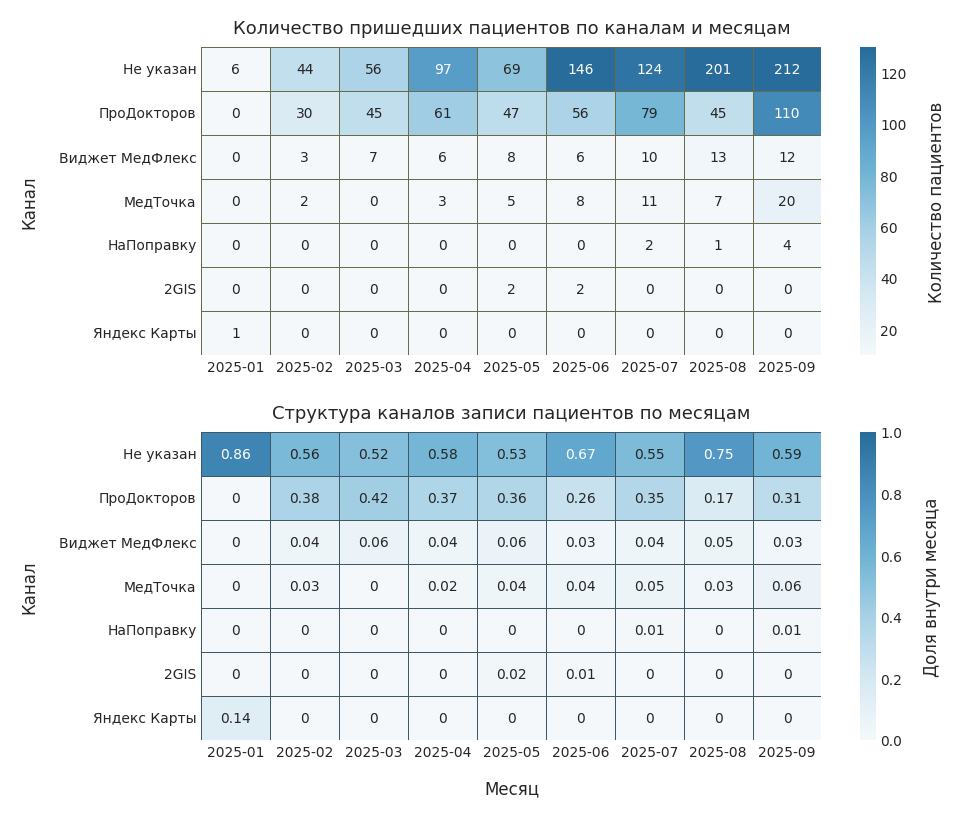

In [32]:
# --- 1. Подготовка данных: количество пациентов ---
pat_per_channel_month = (
    channels
    .groupby(['channel', 'month'])['pat_id']
    .count()
    .unstack(fill_value=0)
)

# Сортировка
pat_per_channel_month = (
    pat_per_channel_month
    .loc[
        pat_per_channel_month
        .sum(axis=1)
        .sort_values(ascending=False)
        .index
    ]
)

# Нормализация по каждому месяцу для отображения долей
df_norm = pat_per_channel_month.copy()
df_norm = df_norm / df_norm.sum(axis=0)
df_norm = df_norm.round(2)


# --- 2. Построение двух тепловых карт (абсолюты и доли) ---
modern_turquoise_soft = LinearSegmentedColormap.from_list(
    "modern_turquoise_soft",
    [
        "#F4F8FA",  # нейтральный, ближе к серо-бирюзовому (фон)
        "#D5E8F2",  # лёгкая бирюзовая дымка
        "#A8D1E6",  # мягкий голубовато-бирюзовый
        "#6FB3D4",  # средний, комфортный оттенок
        "#4A90BF",  # уверенный, но не “кричащий”
        "#276C9B"   # тёмный акцент без потери контраста
    ]
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 9))
plt.subplots_adjust(hspace=0.25)

# Верхний график — абсолютные значения
sns.heatmap(
    pat_per_channel_month,
    annot=True,
    fmt=".0f",
    cmap=modern_turquoise_soft,
    linewidths=0.5,
    linecolor="#696b48",
    cbar_kws={'label': 'Количество пациентов'},
    ax=axes[0],
    vmin=10, vmax=130
)
axes[0].set_title("Количество пришедших пациентов по каналам и месяцам", pad=10)
axes[0].set_xlabel("")
axes[0].set_ylabel("Канал")

# Нижний график — относительные доли (0–1)
sns.heatmap(
    df_norm,
    annot=True,
    cmap=modern_turquoise_soft ,
    linewidths=0.5,
    linecolor="#3e5865",
    cbar_kws={'label': 'Доля внутри месяца'},
    ax=axes[1],
    vmin=0, vmax=1
)
axes[1].set_title("Структура каналов записи пациентов по месяцам", pad=10)
axes[1].set_xlabel("Месяц")
axes[1].set_ylabel("Канал")

plt.savefig(
    "reports/visualisation/fig04_monthly_channel_patient_distribution_heatmap.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

In [33]:
df_norm.mean(axis=1).round(2).reset_index(name='Средняя доля записей')

,channel,Средняя доля записей
0,Не указан,0.62
1,ПроДокторов,0.29
2,Виджет МедФлекс,0.04
3,МедТочка,0.03
4,НаПоправку,0.00
5,2GIS,0.00
6,Яндекс Карты,0.02


Количество записей во все месяцы преобладает в источнике "Не указано". В него может входить любой способ пациенту узнать о клинике, кроме:
- ПроДокторов
- МедФлекс
- МедТочка
- НаПоправку

В среднем доля записавшихся через ПроДокторов составляет 29%, чаще всего пациенты записываются напрямую - 62%, иные известные источники занимают 9%.

**Выводы:** 
- Важно разработать систему отслеживания эффективности рекламных компаний
- Важно доработать сайт для удобства самостоятельной записи пациентов (звонки напрямую + виджет МедФлекс)

***Гипотеза (H3): доля первичных и вторичных пациентов по источникам записи не различается между ПроДокторов и самостоятельной записью пациентов.***

#### Доля первичных и вторичных пациентов по месяцам

In [34]:
# === Определение первичный ли пациент === #
# Расчет количества дней между посещениями
channels = channels.sort_values(['pat_id', 'visit_date'])
channels['days_since_last'] = channels.groupby('pat_id')['visit_date'].diff().dt.days

# Если пришел дважды в первый день - отметится и как первичка, и как вторичка
# Нужно в день первого посещения изменить разницу дней с 0 на np.nan
# То же если несколько посещений в день, но разница с прошлой датой > 90 дней
THRESHOLD_DAYS = 90

# Функция для замены ложно-вторичных записей на np.nan
def fix_fake_secondary(s: pd.Series) -> pd.Series:
    s = s.copy()
    if (s.isna() | (s >= THRESHOLD_DAYS)).any():
        s[:] = np.nan
    return s

# Применение функции к сгруппированным данным
fake_secondary_patient = (
    channels
    .groupby(['pat_id', 'visit_date'], group_keys=False)['days_since_last']
    .apply(fix_fake_secondary)
)

# Замена данных на исправленные
channels['days_since_last'] = fake_secondary_patient

# Присвоение категории пациентам
channels['visit_cat'] = np.where(
    channels['days_since_last'].isna(),
    'Первичный',
    'Вторичный'
)

# Расчет количества уникальных пациентов в каждой категории в каждый месяц
visit_cat_distrib_by_months = (
    channels.groupby(['month', 'visit_cat'])['pat_id']
    .nunique()
    .reset_index(name='count_patients')
)

# Расчет долей
visit_cat_distrib_by_months['share_patients'] = (
    visit_cat_distrib_by_months
    .groupby('month', group_keys=False)['count_patients']
    .transform(lambda x: x / x.sum())
)

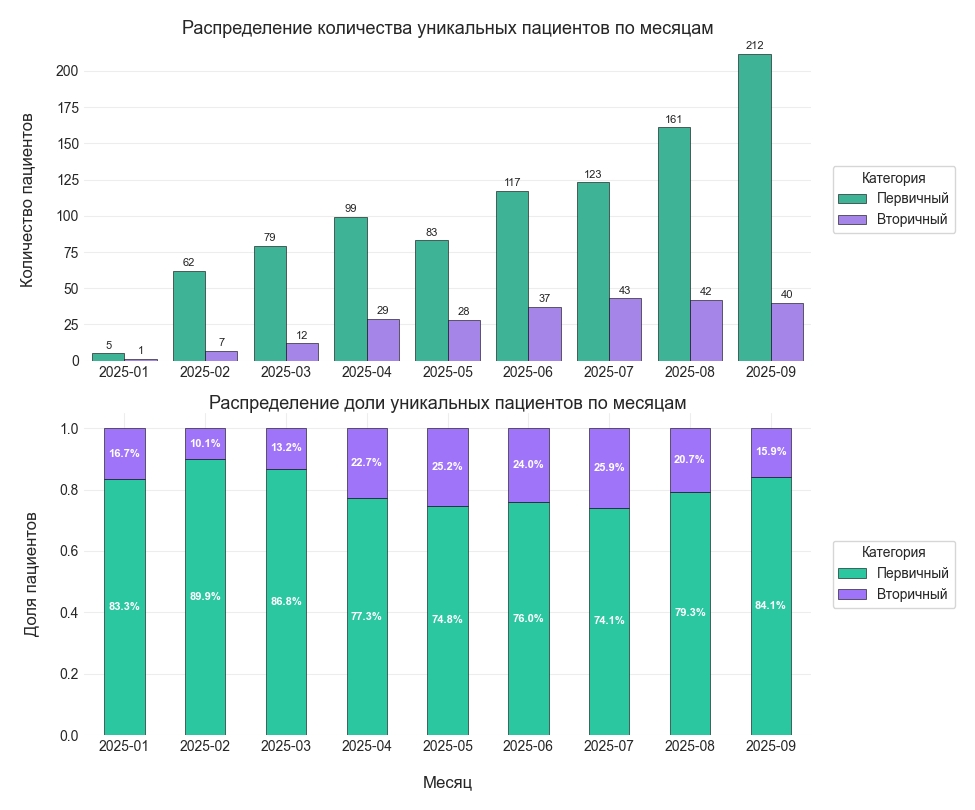

In [35]:
# Визуализация распределения пациентов по первичкам и вторичкам

sns.set_style('whitegrid')

# Палитра
palette = {
    'Вторичный': '#A074F8',  # фиолетовый
    'Первичный': '#2AC7A0'   # бирюзовый
}

order_cat = ['Вторичный', 'Первичный']

fig, axes = plt.subplots(2, 1, figsize=(11, 8))

# === 1. Количество пациентов ===
sns.barplot(
    data=visit_cat_distrib_by_months,
    x='month', y='count_patients',
    hue='visit_cat', hue_order=order_cat[::-1],
    palette=palette, edgecolor='black', linewidth=0.4,
    ax=axes[0]
)

axes[0].set_title('Распределение количества уникальных пациентов по месяцам', pad=3)
axes[0].set_ylabel('Количество пациентов')
axes[0].set_xlabel('')

# Подписи над столбцами
for c in axes[0].containers:
    axes[0].bar_label(c, fmt='%d', label_type='edge', fontsize=8, padding=2)

# === 2. Доля пациентов (stacked barplot) ===
share_pivot = visit_cat_distrib_by_months.pivot(
    index='month', columns='visit_cat', values='share_patients'
).fillna(0)[order_cat[::-1]]

share_pivot.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    color=[palette[col] for col in share_pivot.columns],
    edgecolor='black', linewidth=0.4
)

axes[1].set_title('Распределение доли уникальных пациентов по месяцам', pad=3)
axes[1].set_ylabel('Доля пациентов')
axes[1].set_xlabel('Месяц')

# Подписи процентов
for container in axes[1].containers:
    labels = [f'{v*100:.1f}%' if v > 0 else '' for v in container.datavalues]
    axes[1].bar_label(
        container, labels=labels, label_type='center',
        fontsize=8, color='white', weight='bold'
    )

plt.setp(axes[1].get_xticklabels(), rotation=0)

# === Легенды вынесены вправо ===
axes[0].legend(title='Категория', loc='center left', bbox_to_anchor=(1.02, 0.5))
axes[1].legend(title='Категория', loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout(rect=[0, 0, 0.88, 1])

plt.savefig(
    "reports/visualisation/fig05_primary_secondary_patients_monthly_distribution.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

Количество вторичных пациентов держится на уровне около 40 человек. Прирост пациентов обеспечивается первичным потоком.

Для получения корректных выводов нужно оценить обновляется ли вторичный поток или у клиники есть небольшое количество постоянных клиентов.

**Гипотеза (H4): среди вторичных пациентов низкий отток, большая доля из вторичных - сформированная база в апреле-июне.**

### Структура среднего чека

Средний чек остаётся на сопоставимом уровне с апреля по сентябрь, что может указывать на устойчивость ценовой структуры и потребительского поведения.

Однако сам по себе средний чек не отражает изменения в распределении сумм: за счёт компенсации дешёвых и дорогих услуг он может оставаться стабильным, хотя структура сильно меняется.

Дополнительная проверка:
- Построить боксплоты чеков за июнь и сентябрь.
- Оценить разницу медиан для выявления изменения поведения пациентов.

Цель — проверить гипотезу: “При сохранении среднего значения увеличилась доля малых чеков и одновременно небольшое количество крупных чеков”.

Это позволит понять, растёт ли выручка за счёт массовости мелких визитов или за счёт роста премиальных услуг.

In [36]:
# подготовка данных для визуализации boxplots
list_months = ['2025-09', '2025-08', '2025-07', '2025-06']
visits_june_to_sep = visits.query("month in @list_months")
checks = visits_june_to_sep.groupby(['month', 'check_id'], as_index=False)['amount_rub'].sum()

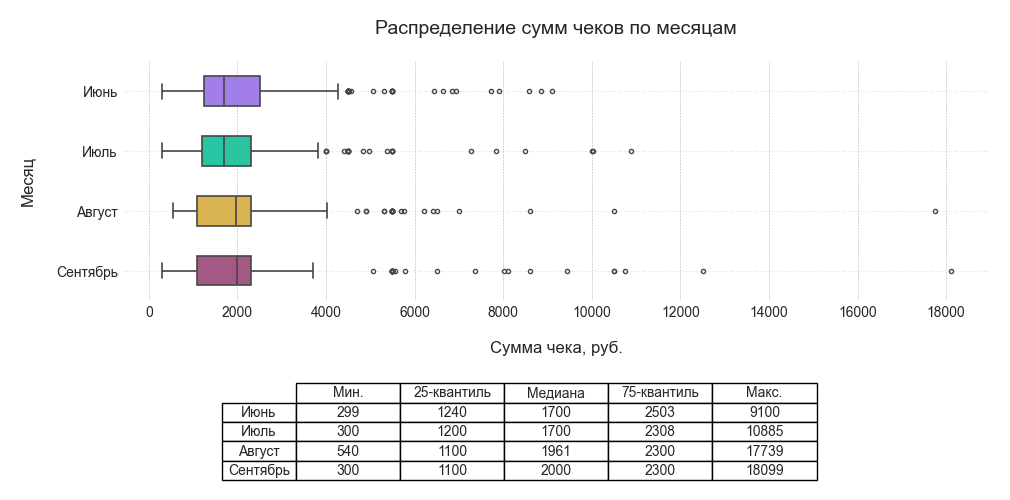

In [37]:
# --- параметры ---
months_to_plot = ['2025-09', '2025-08', '2025-07', '2025-06'][::-1]
custom_palette = ["#9c6ef9", "#0fdeb1ff", "#f1bd3cff", "#b14b88ff"]
# -----------------

# названия месяцев
month_names = {
    '2025-06': 'Июнь',
    '2025-07': 'Июль',
    '2025-08': 'Август',
    '2025-09': 'Сентябрь'
}

subset = checks.query("month in @months_to_plot")
subset = subset.replace({'month': month_names})

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=subset,
    y='month',
    x='amount_rub',
    hue='month',                        # чтобы можно было применить palette
    order=[month_names[m] for m in months_to_plot],
    palette=custom_palette,
    width=0.5,
    linewidth=1.2,
    fliersize=3,
    legend=False                        # убираем дублирующую легенду
)

plt.title('Распределение сумм чеков по месяцам', fontsize=14)
plt.xlabel('Сумма чека, руб.', fontsize=12)
plt.ylabel('Месяц', fontsize=12)
plt.grid(alpha=0.3, linestyle='--')


month_order = ['Июнь', 'Июль', 'Август', 'Сентябрь']

# считаем статистику
stats = (
    subset.groupby('month')['amount_rub']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min', '25%', '50%', '75%', 'max']]
    .rename(columns={
        'min': 'Мин.',
        '25%': '25-квантиль',
        '50%': 'Медиана',
        '75%': '75-квантиль',
        'max': 'Макс.'
    })
    .astype(int)
    .reindex(month_order)
)

# создаём фигуру с двумя зонами: график + таблица
fig = plt.gcf()
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 0.8])  # верх – график, низ – таблица

# переносим текущие оси в верхнюю зону
ax = plt.gca()
ax.set_position(gs[0].get_position(fig))
ax.set_subplotspec(gs[0])
ax.set_xticks(np.arange(0, 20000, 2000))
ax.set_xticklabels([f"{x:.0F}" for x in np.arange(0, 20000, 2000)], fontsize=10)
ax.grid(axis='x', color='black', linestyle='--', linewidth=0.4)

# таблица внизу
ax_table = fig.add_subplot(gs[1])
ax_table.axis('off')
tbl = ax_table.table(
    cellText=stats.values,
    rowLabels=stats.index,
    colLabels=stats.columns,
    cellLoc='center',
    rowLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(0.6, 1.5)

plt.tight_layout()

plt.subplots_adjust(hspace=0.85)

plt.savefig(
    "reports/visualisation/fig06_monthly_check_amount_boxplot.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

Для сравнения средних в скошенных распределениях лучше использовать робастные оценки, например, медиану.

Для оценки устойчивости разницы медиан в данном случае уместным инструментом будет bootstrap.

Сравним данные за июль и август, так как по графику и таблице именно между ними произошло изменение структуры медианного чека.

In [38]:
july_checks = checks.query("month == '2025-07'")['amount_rub'].values
august_checks = checks.query("month == '2025-08'")['amount_rub'].values
september_checks = checks.query("month == '2025-09'")['amount_rub'].values

n_boot = 10000
rng = np.random.default_rng(42)


# === Бутстрап августа и июля === #
median_diffs = np.array([], dtype=float)
for _ in range(n_boot):
    m1 = np.median(rng.choice(july_checks, size=july_checks.shape[0], replace=True))
    m2 = np.median(rng.choice(august_checks, size=august_checks.shape[0], replace=True))
    median_diffs = np.append(median_diffs, m2 - m1)

bounds_CI = np.quantile(median_diffs, [0.025, 0.975])

print('____________________________________________')
print('Сравнение чеков за август и июль'.upper())
print(f'\nМедианный чек (август): \n{np.median(august_checks)}\n')
print(f"95% CI для разницы медиан:\n[{bounds_CI[0]:.0f}, {bounds_CI[1]:.0f}] руб.\n")


# === Бутстрап сентября и июля === #
median_diffs = np.array([], dtype=float)
for _ in range(n_boot):
    m1 = np.median(rng.choice(july_checks, size=july_checks.shape[0], replace=True))
    m2 = np.median(rng.choice(september_checks, size=september_checks.shape[0], replace=True))
    median_diffs = np.append(median_diffs, m2 - m1)

bounds_CI = np.quantile(median_diffs, [0.025, 0.975])

print('____________________________________________')
print('\nСравнение чеков за сентябрь и июль'.upper())
print(f'\nМедианный чек (сентябрь): \n{np.median(september_checks)}\n')
print(f"95% CI для разницы медиан:\n[{bounds_CI[0]:.0f}, {bounds_CI[1]:.0f}] руб.")

____________________________________________
СРАВНЕНИЕ ЧЕКОВ ЗА АВГУСТ И ИЮЛЬ

Медианный чек (август): 
1961.5

95% CI для разницы медиан:
[-75, 300] руб.

____________________________________________

СРАВНЕНИЕ ЧЕКОВ ЗА СЕНТЯБРЬ И ИЮЛЬ

Медианный чек (сентябрь): 
2000.0

95% CI для разницы медиан:
[200, 600] руб.


Для устойчивых, но скошенных распределений (как в случае сумм чеков) медиана оценивалась с помощью бутстрапа (10 000 повторов). Доверительные интервалы строились по процентилям 2.5 % и 97.5 %.

С июля по август медианный чек увеличился на ≈260 руб. (+13 %), однако доверительный интервал бутстрапа для разницы медиан включает 0, что не позволяет утверждать о статистически значимом росте.

Рост медианного чека в сентябре статистически значим (на ~200–600 ₽ относительно июля, 95 % ДИ не включает 0) и, вероятно, связан с изменением структуры оказываемых услуг.

**Гипотеза (H5): увеличение удельного веса анализов в структуре среднего чека привело к росту медианного чека в сентябре.**

Возможная категоризация: приемы специалистов / анализы / лечебные процедуры / диагностические процедуры. 

#### Медианный чек по дням недели

Для выявления причин роста выручки можно также обратиться к распределению медианных чеков по дням недели. Данное распределение позволит определить паттерны поведения основной части пациентов.

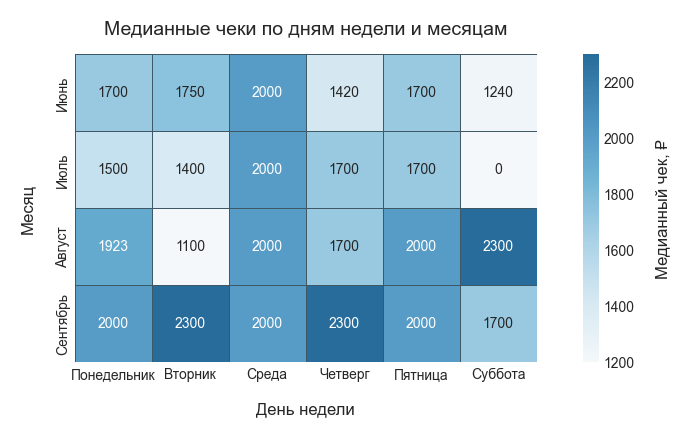

In [39]:
vis = visits.copy().query('month.isin(@list_months)')
vis['day_name'] = vis['date'].dt.day_name()
checks_res = vis.groupby(['check_id', 'day_name', 'month'])['amount_rub'].sum().reset_index()

days_of_week_name_en = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
days_of_week_name_ru = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота']

checks_dow_pivot = checks_res.groupby(['month', 'day_name'])['amount_rub'].median().unstack(fill_value=0).astype(int)
checks_dow_pivot = (checks_dow_pivot
                     .loc[:, days_of_week_name_en]
).rename(columns={en:ru for en, ru in zip(days_of_week_name_en, days_of_week_name_ru)})


fig, ax = plt.subplots(figsize=(12, 4))

# Основная тепловая карта
sns.heatmap(
    checks_dow_pivot,
    annot=True,
    fmt='.0f',
    cmap=modern_turquoise_soft,
    linewidths=0.5,
    linecolor="#3e5865",
    cbar_kws={'label': 'Медианный чек, ₽'},
    square=True,
    ax=ax,
    mask=checks_dow_pivot.isna(),   # используем mask сразу здесь
    vmin=1200,  # явно задаём диапазон цветов
    vmax=checks_dow_pivot.max().max()
)

# Оформление
ax.set_title('Медианные чеки по дням недели и месяцам', fontsize=14, pad=15)
ax.set_xlabel('День недели', fontsize=12)
ax.set_ylabel('Месяц', fontsize=12)
plt.xticks(rotation=0, ha='center')
ax.set_yticklabels(['Июнь', 'Июль', 'Август', 'Сентябрь'])
ax.tick_params(axis='both', labelsize=10)

plt.savefig(
    "reports/visualisation/fig07_median_check_by_weekday_month_heatmap.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

# plt.tight_layout()
plt.show()

Пиковые значения медианных чеков приходятся на дни приема врачей, наработавших высокую репутацию еще до трудоустройства в клинику. Например, пульмонолог начал вести приемы в сентября по вторникам и четвергам, что отражается на медианном чеке.

Тяжело сделать однозначные выводы, потому что старт приемов пульмонолога пришелся на рост заболеваемости ОРВИ. Однако стоит сказать, что в сезон болезней наличие пульмонолога с хорошей репутацией способно привлечь более дорогую аудиторию.

### Динамика выручки

Выручка клиники стабильно растёт с июня по сентябрь — с ~274 тыс. до ~591 тыс. рублей.  
Рост происходит синхронно с увеличением количества **уникальных пациентов** при стабильном среднем чеке.  
Это указывает, что ключевой драйвер — **привлечение новых пациентов**, а не рост цен или среднего чека.

Дополнительно следует проверить:

- Изменился ли вклад одного пациента (ARPU)?
- Какие категории услуг обеспечили наибольший вклад в рост? (проверить в связке с H5)
- Как изменилось удержание новых пациентов? (пересекается с H4)

***Гипотеза (H6): рост выручки обусловлен притоком новых пациентов, а не увеличением числа визитов у существующих (ARPU остаётся стабильным).***

### Удержание пациентов

Рост числа обратившихся пациентов не гарантирует их возвращаемость.

Для анализа метрик удержания стоит провести когортный анализ.

Дополнительные проверки:
- Удержание пациентов по месяцам (проверить в связке с H4)
- Удержание пациентов по категориям услуг (проверить в связке с H2)

## Финальный блок разведочного анализа

**Сформулированные гипотезы**

Рост выручки с июня по сентябрь сопровождается увеличением числа уникальных пациентов при стабильном среднем чеке.  
Это указывает на изменение структуры клиентской базы и состава оказываемых услуг, что подтверждается изменением медианного чека.

**Гипотезы для проверки:**
- **H1–H4:** контекстные гипотезы о сезонности, удержании и распределении пациентов по источникам
- **H5:** рост медианного чека связан с увеличением доли анализов и диагностических процедур
- **H6:** рост выручки обеспечен притоком новых пациентов при стабильном ARPU

*(02_behavior_analysis.ipynb)*

**Следующие шаги:**  
Проверить H5–H6 и сопоставить результаты с гипотезами H1–H4 для выявления ключевых факторов роста и устойчивости клиентской базы.


In [40]:
# Сохранение изменений в данных для дальнейших проверок
visits.to_csv('data/processed/visits_prepared.csv', index=False)
channels.to_csv('data/processed/channels_prepared.csv', index=False)